# 3. Linear Models for Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from prml.distributions import GaussianDistribution
from prml.features import GaussianFeatures, PolynomialFeatures, SigmoidalFeatures
from prml.linear_regressors import LinearRegressor, RidgeRegressor, BayesianLinearRegressor

In [2]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

## 3.1 Linear Basis Function Models

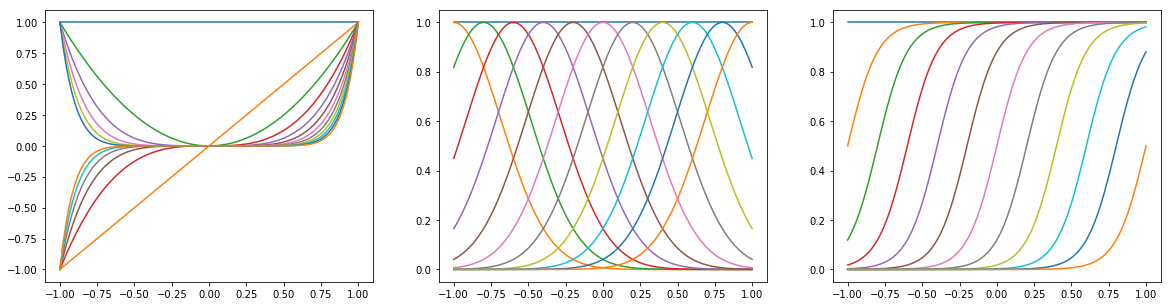

In [3]:
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeatures(11).transform(x[:, None])
X_gaussian = GaussianFeatures(np.linspace(-1, 1, 11), 0.1).transform(x)
X_sigmoidal = SigmoidalFeatures(np.linspace(-1, 1, 11), 10).transform(x)

plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i + 1)
    for j in range(12):
        plt.plot(x, X[:, j])

## 3.1.1 Maximum likelihood and least squares
Training dataset
- inputs ${\bf X} = \{{\bf x}_1, \dots, {\bf x}_N\}$
- targets ${\bf t} = \{t_1, \dots, t_N\}$

Likelihood function
$$p({\bf t}|{\bf X},{\bf w},\beta) = \prod_{n=1}^N\mathcal{N}(t_n|{\bf w}^T{\bf\phi}({\bf x}_n),\beta^{-1})$$
Optimal paratmeters ${\bf w}_{\rm ML}$ and $\beta_{\rm ML}$ that maximizes the likelihood are
$$\begin{align}
{\bf w}_{\rm ML} &= ({\bf\Phi}^T{\bf\Phi})^{-1}{\bf\Phi}^T{\bf t}\\
1/\beta_{\rm ML} &= {1\over N}\|{\bf t} - {\bf\Phi}{\bf w}_{\rm ML}\|^2
\end{align}$$
where design matrix ${\bf\Phi}$ is defined as the following
$$
{\bf\Phi} =
\begin{bmatrix}
\phi_0({\bf x}_1) & \phi_1({\bf x}_1) & \cdots & \phi_{M-1}({\bf x}_1)\\
\phi_0({\bf x}_2) & \phi_1({\bf x}_2) & \cdots & \phi_{M-1}({\bf x}_2)\\
\vdots & \vdots & \ddots & \vdots\\
\phi_0({\bf x}_N) & \phi_1({\bf x}_N) & \cdots & \phi_{M-1}({\bf x}_N)
\end{bmatrix}
$$

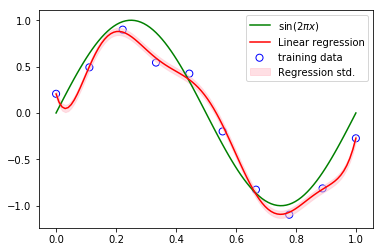

In [4]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

# select one of the three features below
# feature = PolynomialFeatures(8)
feature = GaussianFeatures(np.linspace(0, 1, 8), 0.1)
# feature = SigmoidalFeatures(np.linspace(0, 1, 8), 10)

X_train = feature.transform(x_train)
X_test = feature.transform(x_test)
model = LinearRegressor()
model.fit(X_train, y_train)
y, y_std = model.predict(X_test, with_error=True)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="Linear regression")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="pink", alpha=0.5, label="Regression std.")
plt.legend()
plt.show()

## 3.1.4 Regularized least squares
Cost function for ridge regression is
$${1\over 2}\|{\bf t} - {\bf\Phi}{\bf w}\|^2 + {\alpha\over2}\|{\bf w}\|^2$$
where $\alpha$ controls the strength of the regularization.
The optimal parameter ${\bf w}^*$ that minimizes the cost function is
$${\bf w}^* = (\alpha{\bf I} + {\bf\Phi}^T{\bf\Phi})^{-1}{\bf\Phi}^T{\bf t}$$

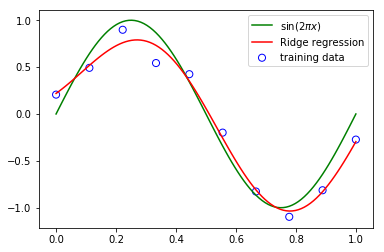

In [5]:
model = RidgeRegressor(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, c="g", label="$\sin(2\pi x)$")
plt.plot(x_test, y, c="r", label="Ridge regression")
plt.legend()
plt.show()

## 3.2 The Bias-Variance Decomposition

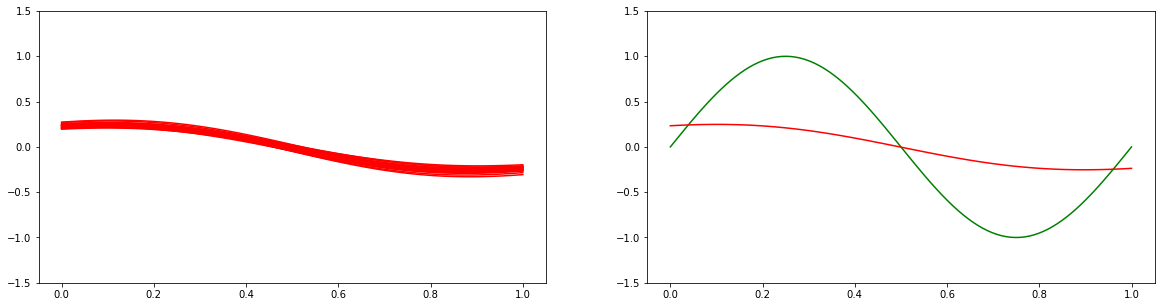

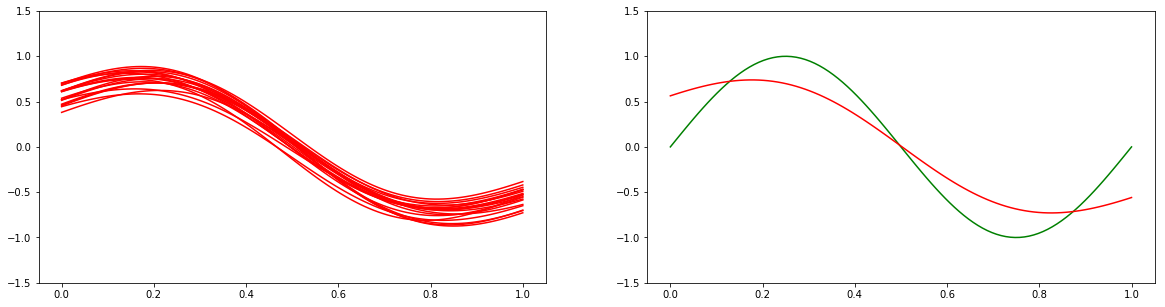

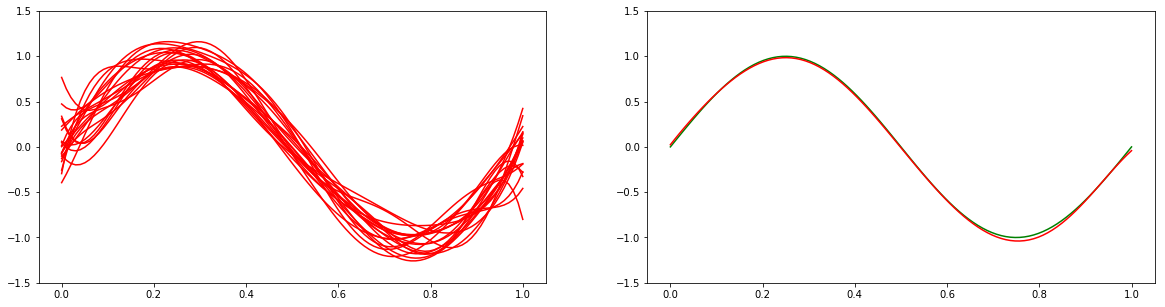

In [6]:
# feature = PolynomialFeatures(24)
feature = GaussianFeatures(np.linspace(0, 1, 24), 0.1)
# feature = SigmoidalFeatures(np.linspace(0, 1, 24), 10)

for a in [1e2, 1., 1e-9]:
    y_list = []
    model = RidgeRegressor(alpha=a)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    for i in range(100):
        x_train, y_train = create_toy_data(sinusoidal, 25, 0.25)
        X_train = feature.transform(x_train)
        X_test = feature.transform(x_test)
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        y_list.append(y)
        if i < 20:
            plt.plot(x_test, y, color="r")
    plt.ylim(-1.5, 1.5)
    
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test, color="g")
    plt.plot(x_test, np.asarray(y_list).mean(axis=0), color="r")
    plt.ylim(-1.5, 1.5)
    plt.show()

## 3.3 Bayesian Linear Regression

### 3.3.1 Parameter distribution
Prior distribution
$$p({\bf w}) = \mathcal{N}({\bf w}|{\bf m}_0,{\bf S}_0)$$
Posterior distribution
$$p({\bf w}|{\bf t}) = \mathcal{N}({\bf w}|{\bf m}_N,{\bf S}_N)$$
where
$$\begin{align}
{\bf m}_N &= {\bf S}_N({\bf S}_0^{-1}{\bf m}_0 + \beta{\bf\Phi}^T{\bf t})\\
{\bf S}_N^{-1} &= {\bf S}_0^{-1} + \beta{\bf\Phi}^T{\bf\Phi}
\end{align}$$

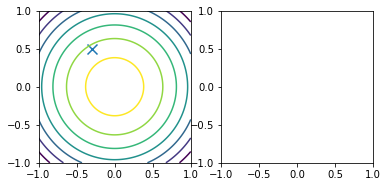

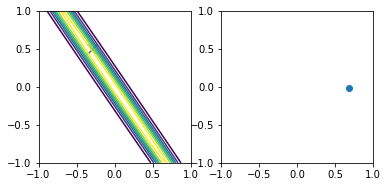

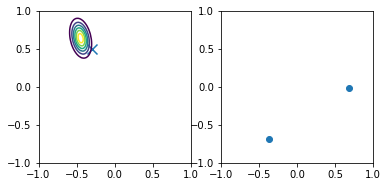

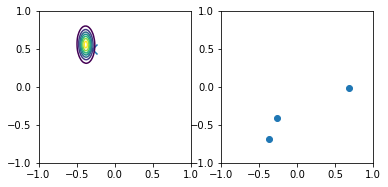

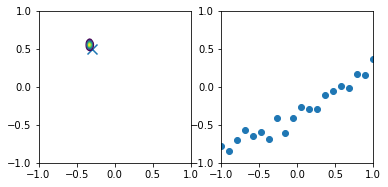

In [7]:
def linear(x):
    return -0.3 + 0.5 * x

x_train, y_train = create_toy_data(linear, 20, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).reshape(2, -1).T

feature = PolynomialFeatures(degree=1)
X_train = feature.transform(x_train)
model = BayesianLinearRegressor(alpha=0.1, beta=100, n_features=2)
gauss_dist = GaussianDistribution()

for begin, end in [[0, 0], [0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit_online(X_train[begin: end], y_train[begin: end])
    gauss_dist.mean = model.w_mean
    gauss_dist.var = model.w_var
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=100, marker="x")
    plt.contour(w0, w1, gauss_dist.proba(w).reshape(100, 100))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:end], y_train[:end])
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 3.3.2 Predictive distribution
$$\begin{align}
p(t|{\bf t},\alpha,\beta) &= \int p(t|{\bf w},\beta)p({\bf w}|{\bf t},\alpha,\beta){\rm d}{\bf w}\\
&= \mathcal{N}(t|{\bf m}_N^T{\bf\phi}({\bf x}),\sigma^2_N({\bf x}))
\end{align}$$
where
$$\sigma^2_N({\bf x}) = {1\over\beta} + {\bf\phi(x)}^T{\bf S}_N{\bf\phi(x)}$$

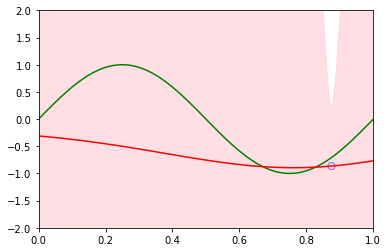

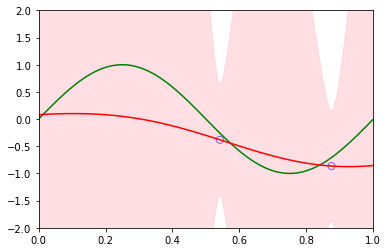

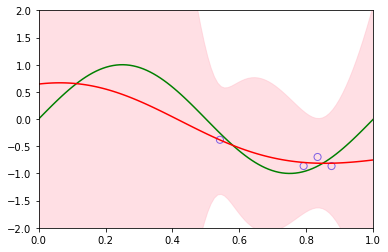

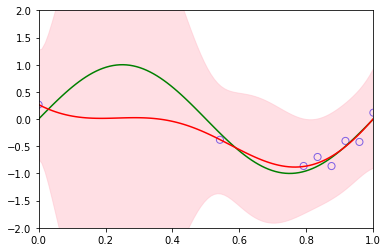

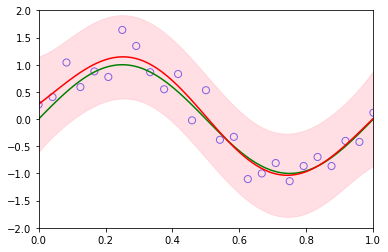

In [8]:
x_train, y_train = create_toy_data(sinusoidal, 25, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

feature = GaussianFeatures(np.linspace(0, 1, 9), 0.1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianLinearRegressor(alpha=1e-3, beta=2)

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    model.fit_online(X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(X_test)
    plt.scatter(x_train[:end], y_train[:end], s=50, facecolor="none", edgecolor="blue")
    plt.plot(x_test, y_test, color="g")
    plt.plot(x_test, y, color="r")
    plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()

# 3.5 The Evidence Approximation

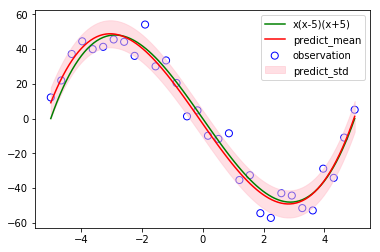

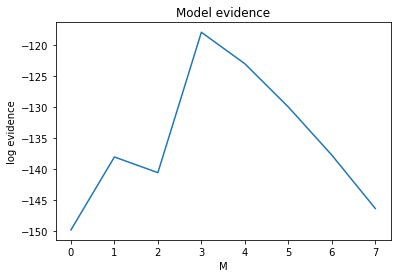

In [9]:
def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 30, 10, [-5, 5])
x_test = np.linspace(-5, 5, 100)
evidences = []
models = []
for i in range(8):
    feature = PolynomialFeatures(degree=i)
    X_train = feature.transform(x_train)
    regression = BayesianLinearRegressor(alpha=100, beta=100)
    regression.maximize_evidence(X_train, y_train)
    evidences.append(regression.log_evidence(X_train, y_train))
    models.append(regression)
degree = np.nanargmax(evidences)
regression = models[degree]

X_test = PolynomialFeatures(degree=int(degree)).transform(x_test)
y, y_std = regression.predict(X_test)

plt.scatter(x_train, y_train, s=50, facecolor="none", edgecolor="b", label="observation")
plt.plot(x_test, cubic(x_test), color="g", label="x(x-5)(x+5)")
plt.plot(x_test, y, color="red", label="predict_mean")
plt.fill_between(x_test, y - y_std, y + y_std, color="pink", alpha=0.5, label="predict_std")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("M")
plt.ylabel("log evidence")
plt.show()